<a href="https://colab.research.google.com/github/makkimaki/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/main/Chapter6_Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前分布をどう決めるか？
- データセットのサイズ依存性
- 線形回帰における事前分布とペナルティの関係
慎重な選び方が時に必要。事前分布は個人的な信念を織り込めるが、**個人的信念を排除したい時**には慎重な選択が必要


- 客観的事前分布：基本的に、全区間、とりうるすべての値をもつものにする e.g.) 一様分布なら[0, 1]など
- 主観的事前分布(情報を含む事前分布, informative prior)

In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12
!pip install numpyro
!pip install 'pymc>=5.9'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4ed64fe67ea7b313de7a2b136080f525bee81a34a095d7988a671b98fbf1c201
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytens

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az
import scipy
import scipy.stats as stats
from numpy.random import multinomial
import matplotlib as mtl
mtl.style.use("ggplot")

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
print(f"{scipy.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.10.4'
sns.__version__='0.12.0'
np.__version__='1.25.2'
scipy.__version__='1.11.4'


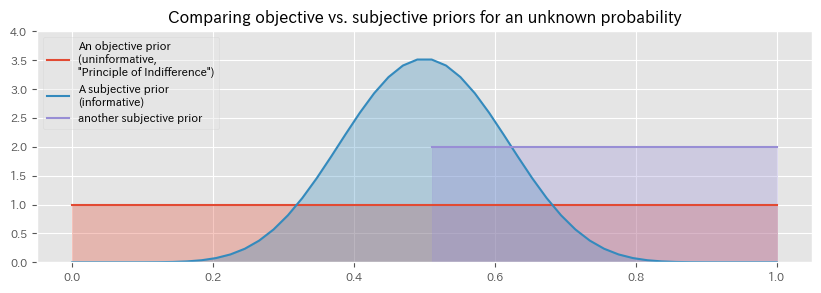

In [3]:
# 主観的(subjective)、客観的(objective)事前分布の例
plt.figure(figsize=(10, 3))
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0, 1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x, y2 ,label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

主観的事前分布というのは、ユーザーの主観的な意見を使うということとは必ずしも一致しない。
他の問題の事後分布が、この問題の事前分布になっているということが多い。

⇨つまり、事後分布の更新が行われている！

### 意思決定に次ぐ意思決定
- 科学的研究⇨客観的事前情報
- 医学的調査報告書
    - 信用に足るか？研究者の望む結果に資するような"**客観的**"事前分布を選んでいるかもしれない

- 客観的事前分布なら一様分布か？⇨そう単純じゃない
    - 未知数がとてつもなく大きい値を取るか？ないなら、使うべきじゃない

### 経験ベイズ（empirical Bayes）
頻度主義とベイズ推論を組み合わせるトリック
- ベイズ主義：$\alpha, \tau$といったハイパーパラメータを持つ
- 経験ベイズ：$\alpha, \tau$の選択には頻度主義の手法を使い、ベイズ推論する

（例） \\
$\sigma=5$の正規分布のパラメータ$\mu$を推定したい
- $\mu$の事前分布には正規分布を使える
- $(\mu_p, \sigma^2_p)$を決める

$\mu_p$の選び方
1. 経験ベイズ：**標本平均を使う、つまり観測データの平均**
1. 普通のベイズ：事前知識、客観的事前分布（平均0, 標準偏差大きめ）の何かを使う
※経験ベイズは、事前分布の設定に観測データ情報を用いるため、二重カウントしているといえる。真の不確実さが過小評価される恐れがある。よってデータ数が大きい場合に使う方が良さそう。

フローの違い

\begin{array}{|c|c|}
\hline
普通のベイズ & 事前分布 ⇨ 観測データ ⇨ 事後分布 \\
\hline
経験ベイズ & 観測データ ⇨ 事前分布 ⇨ 観測データ ⇨ 事後分布 \\
\hline
\end{array}

## ガンマ分布

## ウィシャート分布

## ベータ分布
$$
f_X(x|\alpha, \beta)=\frac{x^{(\alpha-1)}(1-x)^{(\beta-1)}}{B(\alpha, \beta)}
$$
- $\alpha, \beta = 1, 1$の場合、一様分布
- ベータ分布と二項分布の深い関係
    - 確率$p$を推定したいとして、$Beta(\alpha, \beta)$を$pP$の事前分布とする
    - $p$がデータ$X$~$Binomial(N, p)$を観測する
    - 事後分布は、$Beta(\alpha+X, \beta+N-X)$ \\
（例） $p$のprior: $Beta(1,1)$　(一様分布！)、観測データ$X$~$Binomial(N, p)$

⇨posterior: $Beta(\alpha+X, \beta+N-X)=Beta(1+10, 1+25-10), (N=25, X=10, 25回中10回成功した)$

## ベイズ多腕バンディット
- 10台のスロットマシン
- アームをひいて当たりが出る確率は、バンディット（スロットマシン）によって異なる
- その確率はもちろん不明
- **自分の勝ち分を最大化する戦略は？**=「最も良いバンディットがどれなのかをできるだけ早く見抜く」
    - 最良のバンディットでなくても、偶然多く当たるkともある⇨最良バンディットだと信じてしまう
    - 逆もあるはず
    - このまま負け続けるべきか、諦めて他を当たるか？
    - 「探索と利用のジレンマ」：いいバンディットを見つけて、そのまま引き続けるか、もっと良いものがあるかトライするか？

### 応用
- ネット広告  
広告パターンの運用方法で売上を最大化したい
- 生物学  
限られたエネルギーで有益な行動を最適化する、最大化する
- 金融  
どのストックオプションのリターンが高いか？
- 臨床試験  

ベイズバンディット：https://sites.socsci.uci.edu/~ivan/asmb.874.pdf

### 解法
- 事前情報なしからスタート
- システムをテストしながらデータ収集
- データと結果を収集しながら最良の行動を学習する

 **ベイズバンディット**
- 各バンディットで勝つ確率の事前分布を仮定することからスタート
1. 各バンディット$b$のpriorから結果$X_b$をランダムランプリング：今回の例題では一様分布を使用
1. 最良のサンプルを出したバンディット$B$を選択　i.e.) $B=$argmax$X_b$
1. バンディット$B$の結果を観測し、バンディット$B$のpriorを更新
1. 1に戻る

$N$個の分布（バンディット$B$の個数？）からのサンプリング  
- 事前分布は[0,1]の一様分布(=$Beta(\alpha=1, \beta=1)$)
- 観測結果は二値。  
⇨事後分布: $Beta(\alpha=1+X, \beta=1+1-X)$

他の注意点
- 負けを出したバンディットをすぐに捨てはしない
- 負けたバンディットを選択する確率を残しておく（確率を減少させる必要はある）
  
  
    
### ベイズバンディットの実装
- `Bandits`: バンディットを定義するクラス
- `BayesianStrategy`: 学習戦略を実装するクラス

## [ChatGPTによる解説]  
この`BayesianStrategy`クラスは、マルチアームド・バンディット問題を解決するためのオンライン学習戦略を実装しています。この問題では、複数の選択肢（バンディット）の中から、最も報酬を最大化する選択肢を繰り返し選ぶ戦略を求めます。このクラスはベイズ統計を用いて、選択肢の期待報酬を学習し、適応的に最良の選択を行います。

#### **パラメータ**
`bandits`: `.pull`メソッドを持つ`Bandits`クラスのインスタンス。各バンディットが報酬を出す確率を表します。
#### **属性**
- `N`: サンプルの累積数。
- `choices`: 履歴上の選択を示す配列。
- `bb_score`: 履歴上のスコアを示す配列。
- `wins`: 各バンディットから得た報酬の累積数。
- `trials`: 各バンディットに対する試行の総数。

#### **メソッド**
- `sample_bandits(n=1)`: `n`回の引きをサンプリングして、その結果を学習に利用します。このメソッドは以下の手順で実行されます：
1. 各バンディットに対して、ベータ分布からサンプリングを行い、最も大きなサンプル値を持つバンディットを選択します。ベータ分布のパラメータは、そのバンディットの勝利数（`wins`）と試行数（`trials`）から計算されます。
1. 選択されたバンディットを引き（`.pull`メソッドの呼び出し）、結果（報酬の有無）を取得します。
選択したバンディットの`wins`と`trials`を更新します。
この試行の結果（報酬の有無）と選択したバンディットのインデックスを履歴に記録します。  

この戦略では、各バンディットの勝利数と試行数から計算されるベータ分布を用いて、各選択肢の期待報酬を推定し、その推定に基づいて次に最も報酬が高いと思われるバンディットを選択します。このアプローチにより、探索（未知のバンディットを試すこと）と搾取（既知の情報をもとに最良と思われる選択を行うこと）のバランスを取りながら、最適な選択を学習していきます。











In [4]:
class Bandits(object):
    """
    N台のバンディットマシンを表すクラスです。
    各バンディットは異なる確率で報酬を出します。このクラスは、特定のバンディットを引いた際の結果をシミュレートするために使用されます。

    Parameters:
        p_array (np.ndarray): 報酬を出す確率を示すNumpy配列。各要素は0より大きく1未満の値です。

    Attributes:
        p (np.ndarray): 各バンディットが報酬を出す確率を保持する配列。
        optimal (int): 最も報酬確率が高いバンディットのインデックス。

    Methods:
        pull(i):
            指定されたバンディットを"引く"操作をシミュレートします。

            Args:
                i (int): 引くバンディットのインデックス。

            Returns:
                int: バンディットが報酬を出す場合は1、そうでない場合は0。

        __len__():
            このインスタンスが保持するバンディットの数を返します。

            Returns:
                int: バンディットの総数。
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        """
        指定されたバンディットを"引く"操作をシミュレートします。
        i番目のバンディットを引いた際に、そのバンディットが報酬を出すかどうかをシミュレートします。報酬を出す確率は、バンディットの確率`p[i]`に基づきます。

        Args:
            i (int): 引くバンディットのインデックス。

        Returns:
            int: バンディットが報酬を出す場合は1、そうでない場合は0。
        """
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):
    def __init__(self, bandits, rate=1.0):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        self.rate = rate

    def sample_bandits(self, n=1):
        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # バンディットの事前分布からサンプリングし、最も値の大きいサンプルを選択する
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))

            # 選択したバンディットからのサンプリング
            result = self.bandits.pull(choice) # 0か1が入る

            # 事前分布とスコアの更新
            # self.wins[choice] += result
            self.wins[choice] = self.wins[choice] * self.rate + result
            # self.trials[choice] += 1
            self.trials[choice] = self.trials[choice] * self.rate + 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return


In [5]:
p_array = np.array([0.1, 0.5, 0.9])  # 3台のバンディットの報酬確率
bandits = Bandits(p_array)
print(bandits.pull(2))  # 2番目のバンディット（インデックスは0から始まる）を引く
print(len(bandits))  # バンディットの数を表示


True
3


In [6]:
# plt.figure(figsize=(11,10))

beta = stats.beta
x = np.linspace(0.001, 0.999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials

    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1+trials[i]-wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label=f"underlying probability:{prob[i]:.2f}")
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title(f"Posteriors After {bayesian_strategy.N} pull" + "s"*(bayesian_strategy.N > 1) )
        plt.autoscale(tight=True)
    # plt.show()
    return

In [7]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

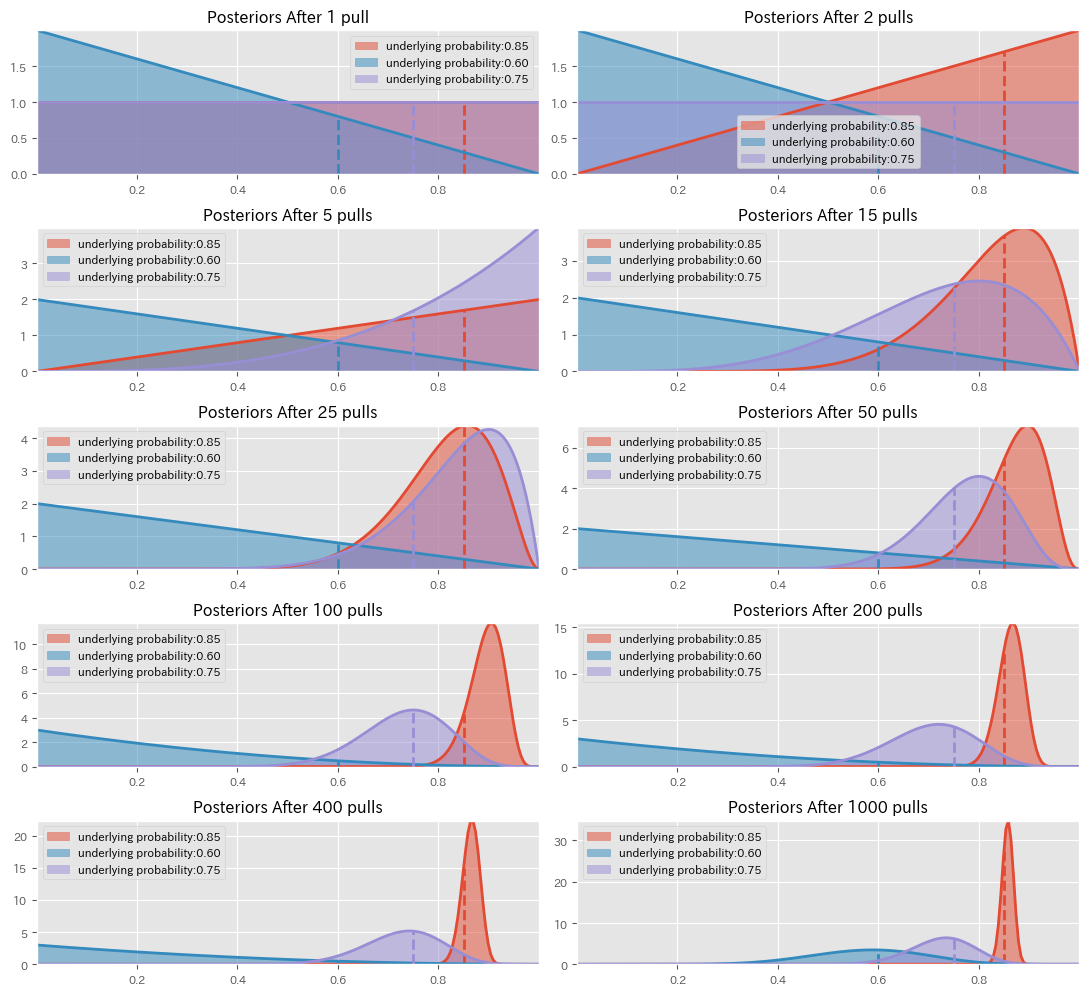

In [8]:
rate = 1.0
bayesian_strat = BayesianStrategy(bandits, rate=rate)

plt.figure(figsize=(11,10))

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=2, alpha=0.5)
    plt.legend()
    plt.autoscale(tight=True)

plt.tight_layout()

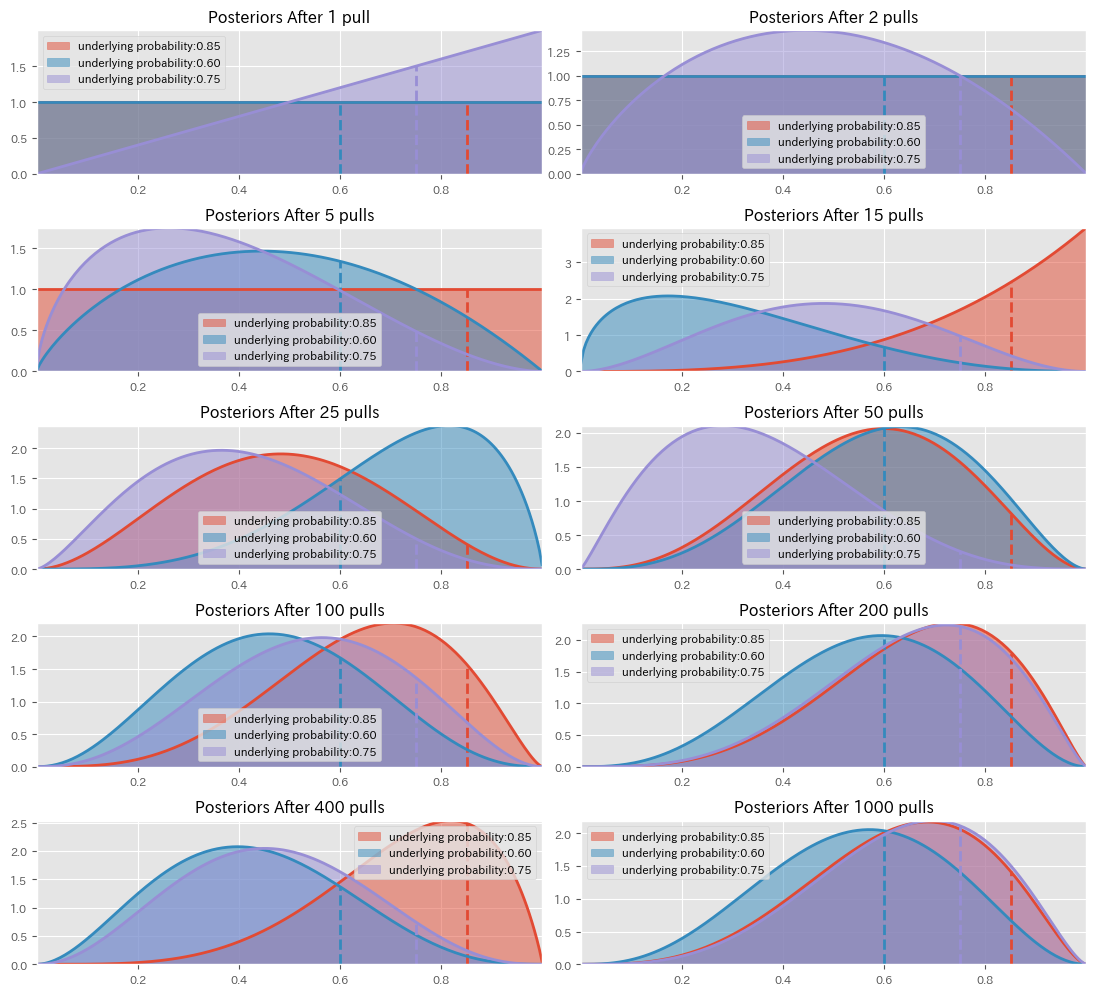

In [9]:
rate = 0.8
bayesian_strat = BayesianStrategy(bandits, rate=rate)

plt.figure(figsize=(11,10))

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=2, alpha=0.5)
    plt.legend()
    plt.autoscale(tight=True)

plt.tight_layout()

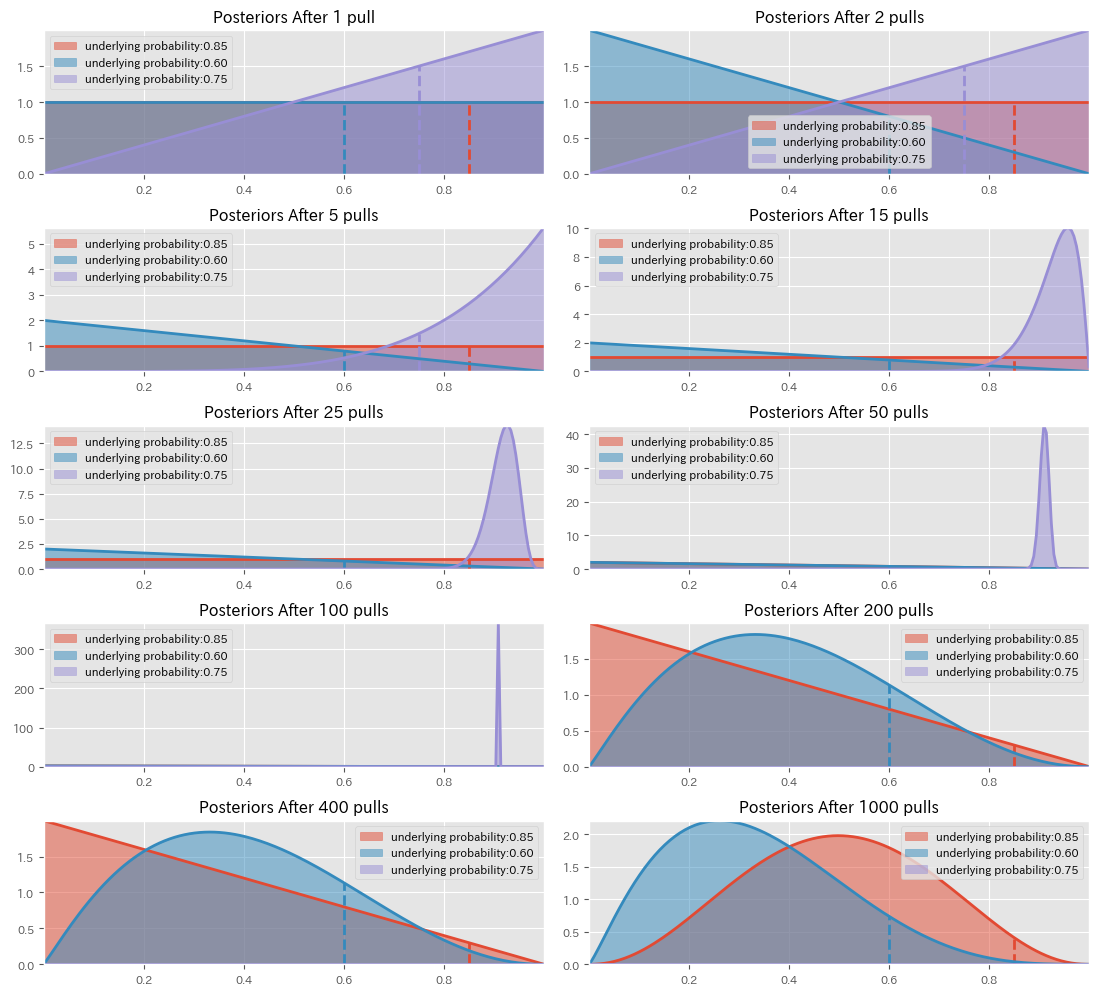

In [10]:
rate = 1.1
bayesian_strat = BayesianStrategy(bandits, rate=rate)

plt.figure(figsize=(11,10))

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=2, alpha=0.5)
    plt.legend()
    plt.autoscale(tight=True)

plt.tight_layout()

In [11]:
# from IPython.core.display import HTML

# # try executing the below command twice if the first time doesn't work
# # 以下のhtmlファイルを別途アップロード必要
# HTML(filename = "BanditsD3.html")

<BarContainer object of 35 artists>

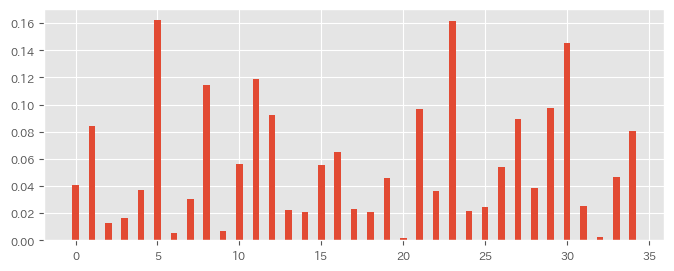

In [12]:
plt.figure(figsize=(8, 3))

beta = stats.beta
hidden_prob = beta.rvs(1, 13, size=35)
# print(f"{hidden_prob:.3f}")
idx = [i for i in range(35)]
plt.bar(idx, hidden_prob, width=0.4)

<ipython-input-13-1b27f6d4dc96>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, j+1)


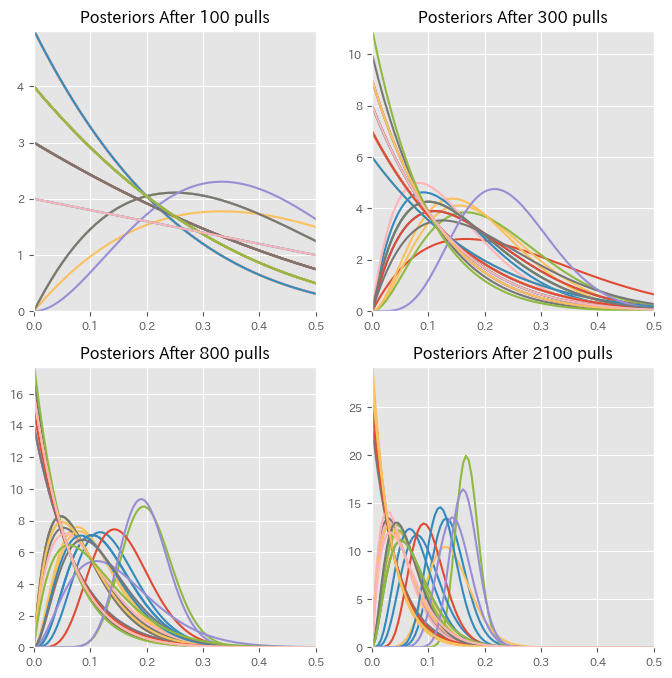

In [13]:
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

plt.figure(figsize=(8, 8))
plt.title("35種類の異なるバンディットを学習したベイズバンディット戦略の更新の様子")
for j, i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=1.5, alpha=0.0, plt_vlines=False)
    plt.xlim(0, 0.5)

plt.show()

## 専門家から事前分布を引き出す
- ドメイン知識を持つ専門家からうまく情報を抜き出したいが、ガンマ分布がどうとか、正規分布がどうとか、そんな話をし出したら素人も混乱する。

- また、その経験を聞いてロングテールの稀なイベントを無視してしまうことがあり、分布の平均付近に大きすぎる重みを置いてしまうことがある。

- そして、推論結果の不確実性を過小評価する

### ルーレット法
略

#### 例題：株売買の収益
- 株の日時リターンを追求したい
    - t日目の株価 $S_t$
    - リターン $r_t$
    - 期待日次リターン

\begin{align*}   
r_t &= \frac{S_t-S_{t-1}}{S_{t-1}} \\
\mu &= E[r_t]
\end{align*}

この$\mu$を不確実性も込みで評価したい。
⇨AAPL, GOOG, TSLA, AMZNで見てみる。
- 「それぞれの会社はどのようなリターン特性を持つか？」ファンドマネージャーに尋ねておく
- ルーレット法で作ってもらう（←これほんと意味ある？）

そのリターン特性を以下に示す。
    

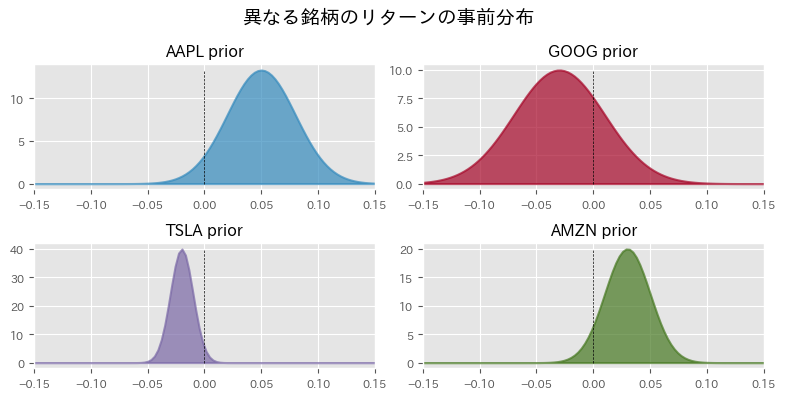

In [52]:

colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04),
                 "TSLA": (-0.02, 0.01),
                 "AMZN": (0.03, 0.02),
                 }

plt.figure(figsize=(8,4))
for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    # plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=1.5,
                     edgecolor = colors[i], alpha = 0.7)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
# plt.title("異なる銘柄のリターンの事前分布")
plt.suptitle("異なる銘柄のリターンの事前分布", size =14);
plt.tight_layout()

In [34]:
# !pip install pandas_datareader --upgrade
!pip install yfinance

In [44]:
import datetime
import collections
import pandas as pd
# import pandas_datareader as pdr
from pandas_datareader import data as dd
import yfinance as yf
yf.pdr_override()
# print(f"{pdr.__version__=}")


n_observations = 100

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2022-04-27"
startdate = "2017-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    # data = pdr.get_data_yahoo(stock, start=startdate, end=enddate)["Close"]
    data = dd.get_data_yahoo(stock, start=startdate, end=enddate)["Close"]
    stock_closes[stock] = data

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]

dates = stock_returns.index.to_list()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [45]:
import pytensor.tensor as pt
from pytensor.tensor.nlinalg import matrix_inverse, matrix_dot
from pytensor.tensor.basic import diag
prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, initval = init)

    mu = pm.Normal("returns", mu=prior_mu, sigma=1, shape=4)

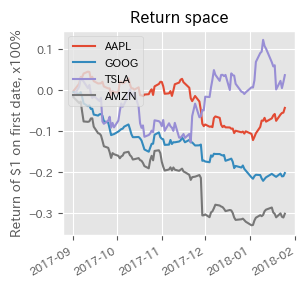

In [46]:
# plt.figure(figsize=(15, 3))
cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates[::-1]
cum_returns.plot()

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

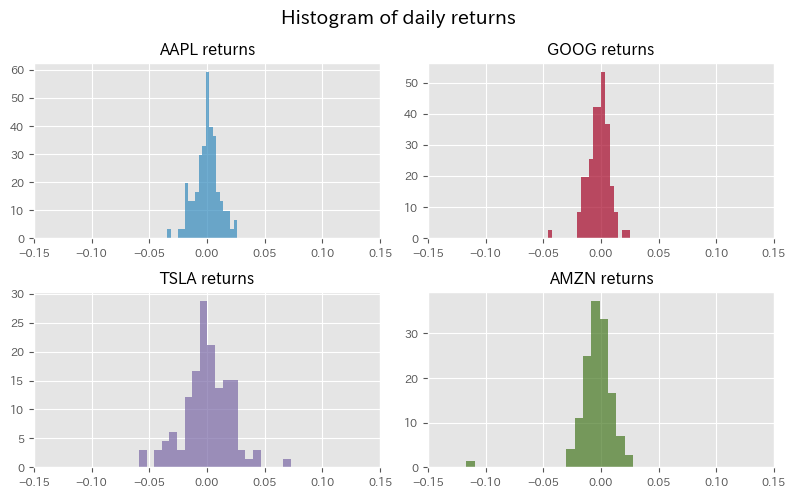

In [53]:
plt.figure(figsize=(8, 5))
for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             density = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)
plt.suptitle("Histogram of daily returns", size =14)
plt.tight_layout();